Book Recommender System


In [61]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score


In [62]:
#reading the files
books = pd.read_csv('data/books.csv', encoding = "ISO-8859-1")
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [63]:
books.shape

(10000, 23)

The books table has 10,000 observations and 23 columns.

In [64]:
book_tags = pd.read_csv('data/book_tags.csv', encoding = "ISO-8859-1")
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [65]:
book_tags.shape

(999912, 3)

The book tags table has 999912 observations and 3 columns

In [66]:
ratings = pd.read_csv('data/ratings.csv', encoding = "ISO-8859-1")
ratings.head()


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [67]:
ratings.shape

(981756, 3)

In [68]:
tags = pd.read_csv('data/tags.csv', encoding = "ISO-8859-1")
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [69]:
tags.shape

(34252, 2)

The tags table has 34252 rows and 2 columns

In [70]:
to_read = pd.read_csv('data/to_read.csv', encoding = "ISO-8859-1")
to_read.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [71]:
to_read.shape

(912705, 2)

The table to_read has 912705 observations and 2 columns

## Exploratory data analysis
Let's see various distributions of the data
1. Missing values

In [72]:
books.isna().mean()

id                           0.0000
book_id                      0.0000
best_book_id                 0.0000
work_id                      0.0000
books_count                  0.0000
isbn                         0.0700
isbn13                       0.0585
authors                      0.0000
original_publication_year    0.0021
original_title               0.0585
title                        0.0000
language_code                0.1084
average_rating               0.0000
ratings_count                0.0000
work_ratings_count           0.0000
work_text_reviews_count      0.0000
ratings_1                    0.0000
ratings_2                    0.0000
ratings_3                    0.0000
ratings_4                    0.0000
ratings_5                    0.0000
image_url                    0.0000
small_image_url              0.0000
dtype: float64

Language code, isbn and original title have missing values. We can drop rows where original title is missing

In [73]:
book_tags.isna().mean()

goodreads_book_id    0.0
tag_id               0.0
count                0.0
dtype: float64

In [74]:
ratings.isna().mean()

book_id    0.0
user_id    0.0
rating     0.0
dtype: float64

In [75]:
tags.isna().mean()

tag_id      0.0
tag_name    0.0
dtype: float64

In [76]:
to_read.isna().mean()

user_id    0.0
book_id    0.0
dtype: float64

Rest of the tables do nto have any missing values. Let's also remove the duplicate values.

In [77]:
ratings.drop_duplicates(subset =["user_id","book_id"], 
                     keep = False, inplace = True) 
ratings.shape

(977269, 3)

 4487 duplicates were removed

In [78]:
print(books.shape)
books.drop_duplicates(subset='original_title',keep=False,inplace=True)
print(books.shape)

(10000, 23)
(9151, 23)


849 rows removed.

In [79]:
print(tags.shape)
tags.drop_duplicates(subset='tag_id',keep=False,inplace=True)
print(tags.shape)

(34252, 2)
(34252, 2)


There are no duplicates in tags.

In [80]:
print(book_tags.shape)
book_tags.drop_duplicates(subset=['tag_id','goodreads_book_id'],keep=False,inplace=True)
print(book_tags.shape)

(999912, 3)
(999896, 3)


### Visualization

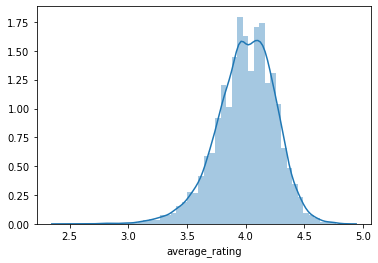

In [81]:
sns.distplot(a=books['average_rating'], kde=True);

Most of the average ratings fall between 3.5-4.5

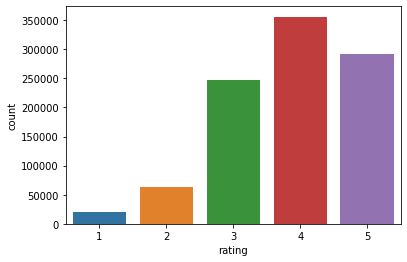

In [82]:
fig=sns.countplot(x=ratings['rating']);

Most of the ratings fall between 3-5

In [83]:
top_rated=books.sort_values('average_rating', ascending=False)
top10=top_rated.head(10)
f=['title','small_image_url']
displ=(top10[f])
displ.set_index('title', inplace=True)

In [88]:
import pandas as pd
from IPython.display import Image, HTML

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'
pd.set_option('display.max_colwidth', -1)
HTML(displ.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html)))

,small_image_url
title,
The Complete Calvin and Hobbes,
"Words of Radiance (The Stormlight Archive, #2)",
Mark of the Lion Trilogy,
It's a Magical World: A Calvin and Hobbes Collection,
There's Treasure Everywhere: A Calvin and Hobbes Collection,
"Harry Potter Boxset (Harry Potter, #1-7)",
"Harry Potter Collection (Harry Potter, #1-6)",
The Indispensable Calvin and Hobbes,
The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury,


Top 10 rated books